# Implementação do Algoritmo de Boosting (Stump Tree Boosting)

## 1 Setup

### 1.1 Carregando o dataset

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split

In [2]:
columns=['Q1','Q2','Q3','Q4','Q5','Q6','Q7','Q8','Q9', 'XResult']

In [3]:
data = pd.read_csv('tic-tac-toe.data', names=columns, header=None)

In [4]:
data.head()

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,XResult
0,x,x,x,x,o,o,x,o,o,positive
1,x,x,x,x,o,o,o,x,o,positive
2,x,x,x,x,o,o,o,o,x,positive
3,x,x,x,x,o,o,o,b,b,positive
4,x,x,x,x,o,o,b,o,b,positive


### 1.2 Tratando os dados

- Lidando com campos não númericos
    - "positive" vira 1
    - "negative" vira -1

In [5]:
data = data.replace("positive", 1, regex=True)
data = data.replace("negative", -1, regex=True)

In [6]:
data = data.replace("x", 1, regex=True)
data = data.replace("o", -1, regex=True)
data = data.replace("b", 0, regex=True)

In [7]:
data.head()

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,XResult
0,1,1,1,1,-1,-1,1,-1,-1,1
1,1,1,1,1,-1,-1,-1,1,-1,1
2,1,1,1,1,-1,-1,-1,-1,1,1
3,1,1,1,1,-1,-1,-1,0,0,1
4,1,1,1,1,-1,-1,0,-1,0,1


- Separando `Features` de `Target Output`

In [8]:
features_data = data.iloc[:, :-1]

In [9]:
features_data.head().values

array([[ 1,  1,  1,  1, -1, -1,  1, -1, -1],
       [ 1,  1,  1,  1, -1, -1, -1,  1, -1],
       [ 1,  1,  1,  1, -1, -1, -1, -1,  1],
       [ 1,  1,  1,  1, -1, -1, -1,  0,  0],
       [ 1,  1,  1,  1, -1, -1,  0, -1,  0]], dtype=int64)

In [10]:
output_data = data.iloc[:, -1]

In [11]:
output_data.head().values

array([1, 1, 1, 1, 1], dtype=int64)

### 1.3 Estabelecendo conjuntos treino e teste

- Dividimos "feature" e "output" em treino(80%) e teste(20%), de forma aleatória:

In [12]:
X = features_data.values
y = output_data.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [13]:
X_train[200]

array([ 1,  1,  1,  0, -1,  0, -1,  0,  0], dtype=int64)

In [14]:
print(len(X_train))
print(len(X_test))

766
192


### 2 Implementação de Boosting

Classificação binária:
- Nossas features são o estado dos quadrantes, o estado do tabuleiro, podendo conter X, O ou B (vazio)
- Nossa output é +1 se X ganhou, -1 se X não ganhou


#### 2.1 Funções auxiliares

Tendo em vista a baixa complexidade do problema e a quantidade baixa de features, produziremos de antemão um grupo de  com todas as possiblidades de Stumps.

Os stumps contém informação sobre a feature que consideram, o valor que vão verificar se a feature se iguala e a predição (-1, 1) feita quando for verificada igualdade.

In [15]:
def createStump(splittingFeature, value, prediction):
    stump = {'splittingFeature' : splittingFeature,
             'value'            : value,
             'prediction'       : prediction}
    return stump 

A stump pool consiste no grupo com todas as possibilidades p/ Stumps.

In [16]:
def createStumpPool(features,values):
    stumpPool = []
    
    stumpPool.append(createStump(None,None,1))
    stumpPool.append(createStump(None,None,-1))
    
    for v in values:
        for f in features:
            stumpPool.append(createStump(f,v,1))
            stumpPool.append(createStump(f,v,-1))
    
    return stumpPool        

A função classify() faz as predições dados um stump e um grupo de features.

In [17]:
def classify(stump, X):
    yPred = np.zeros((len(X)))
    for i in range (len(X)):
        yPred[i] = stump['prediction']
        if (stump['splittingFeature'] != None):       
            if (int(X[i][stump['splittingFeature']]) == stump['value']):
                yPred[i] = stump['prediction']
            else:
                yPred[i] = -(stump['prediction'])
    return yPred


Abaixo temos uma função para evocar classify para todos os stumps da pool.

In [18]:
def poolClassify(stumpPool, X):
#     y = np.zeros((len stumpPool, len(X)))
    yLists = []
    for s in  range(len(stumpPool)):
        cl = classify(stumpPool[s],X)
        yLists.append(cl)
    return yLists

A função _predictionMissIndexes()_ abaixo verifica e retorna índices de acerto e de erro no vetor de previsões.

In [19]:
def predictionMissIndexes(yPred, yTarget):
    miss = []
    hit = []
    for i in range (len(yPred)):
        if yPred[i] != int(yTarget[i]):
            miss.append(i)      
        else:
            hit.append(i)      
    return miss, hit

_MissIndexesCollection()_ abaixo evoca _predictionMissIndexes()_ para todos os stumps da pool, tendo em vista que suas listas de predição estão compiladas em yPredList.

In [20]:
def missIndexesCollection(yPredList, yTarget):
    missCollection = []
    hitCollection = []
    for i in range (len(yPredList)):
        miss, hit = predictionMissIndexes(yPredList[i], yTarget)
        missCollection.append(miss)    
        hitCollection.append(hit)
    return missCollection, hitCollection

_PredictionErrorScore()_ calcula o erro ponderado da previsão, isto é, soma e retorna os pesos das previsões erradas.

In [21]:
def predictionErrorScore(dataWeight, miss):
    error = 0
    for i in miss:
        error += dataWeight[i]
    return error

_ErrorRate()_ calcula o erro não ponderado, baseado apenas na quantia de erros e na quantidade de amostras.

In [22]:
def errorRate(X, miss):
    return len(miss)/len(X)    

_pickBestStump()_ é a função que encontra e retorna o melhor stump dada uma configuração dos pesos. Baseia-se no erro ponderado.

In [23]:
def pickBestStump(miss, dataWeight):
    bestStumpIdx  = 0
    minErrorVal = 1 
    
    for i in range(len(miss)):
        currError = predictionErrorScore(dataWeight, miss[i])
        if(currError < minErrorVal):
            minErrorVal = currError
            bestStumpIdx = i
    
    return bestStumpIdx, minErrorVal

#### 2.2 Algoritmo de boosting

In [24]:
from math import log
from math import exp

###### Função de geração do classificador

Auxiliada pelas funções apresentadas anteriormente, abaixo temos a nossa função de boosting. A função treina um classificador, dado pela combinação de _ensemble e alphas_, isto é, da escolha de stumps associada a um peso alpha.

A função recebe:
- X : features
- y : target
- featureColumns : índice das colunas das features que serão usadas
- featurePossibleValues : valores que as features podem assumir (-1, 0 e 1; anteriormente o, b, x)
    - Optamos por usar esse parâmetro para viabilizar a estratégia de geração prévia dos stumps, considerando a baixa complexidade do conjunto de dados com que estamos trabalhando neste trabalho prático.
- iterations : quantidade de iterações

In [25]:
def printDetails(iteration, epsilon, alpha, bestStump, weights):
    print("-------------- Iteration ",iteration, "--------------")
    print("cur. weights sample: ", weights)
    print("BestStump: ", bestStump)
    print("Epsilon: ", epsilon)
    print("Alpha: ", alpha)
    print("------------------------------------------")
    
    

In [26]:
def boosting(X, y, featureColumns, featurePossibleValues, iterations, printing = False):
    dataWeight = np.full((len(X)), 1/len(X), dtype=float) 
    alphas = np.zeros((iterations))
    stumpPool = createStumpPool(featureColumns, featurePossibleValues)
    y_pred_lists = poolClassify(stumpPool, X)    
    missCollection, hitCollection = missIndexesCollection(y_pred_lists, y)
    
    ensemble = []
    for i in range(iterations):
        #Escolhe o melhor stump e calcula seu epsilon
        bestStumpIdx,epsilon = pickBestStump(missCollection, dataWeight)
        
        #Calcula alpha da iteração atual
        alphas[i] = 0.5 * log((1-epsilon)/float(epsilon))
               
        if printing: printDetails(i, epsilon, alphas[i], stumpPool[bestStumpIdx], dataWeight[:12])    
            
        #Recalcula pesos para os casos de erro e acerto
        for j in missCollection[bestStumpIdx]:
            dataWeight[j] = dataWeight[j]*exp(alphas[i])
        
        for k in hitCollection[bestStumpIdx]:
            dataWeight[k] = dataWeight[k]*exp(-alphas[i])
        
        #Regularizador para tornar soma dos pesos = 1
        dataWeight = dataWeight / float(dataWeight.sum())
        ensemble.append(stumpPool[bestStumpIdx])
    return ensemble, alphas
        

###### Função de predição

A predição ocorre da seguinte forma:
- Caso a soma das predições dos stumps (ponderadas pelo alpha correspondente):
    - resultem em um valor > 0: predição  = 1
    - resultem em um valor <= 0: predição = -1

In [27]:
def predict(alphas, ensemble, X):
    
    yPredLists = poolClassify(ensemble, X);
    yPred = np.zeros((len(yPredLists[0])))
    
    for i in range(len(yPredLists)):        
        yPredLists[i] = yPredLists[i] * alphas[i] 
        yPred += yPredLists[i]
    
    for j in range(len(yPred)):
        if(yPred[j] > 0):
            yPred[j] = 1
        else:
            yPred[j] = -1

    return yPred

### 3 Experimentos

#### 3.1 Validação cruzada 5-fold

A validação cruzada k-fold foi implementada manualmente, podendo ser executada nas células abaixo.

In [28]:
import random

Método para a partição de conjuntos de treino e teste, dentro da fase de validação.

In [29]:
def kfoldcv(indices, k = 5, seed = 42):
    size = len(indices)
    subset_size = round(size / k)
    random.Random(seed).shuffle(indices)
    subsets = [indices[x:x+subset_size] for x in range(0, len(indices), subset_size)]
    kfolds = []
    for i in range(k):
        test = subsets[i]
        train = []
        for subset in subsets:
            if subset != test:
                train += subset
        kfolds.append((train,test))
        
    return kfolds

In [30]:
ix = list(range(len(X_train)))
kfolds = kfoldcv(ix)

Com o intuito de comparar o desempenho do classificador para variações do parâmetro _iterations_, realizamos múltiplas execuções. 

In [31]:
iterationsGrid = list(range(128))
iterationsGrid = [element * 2 for element in iterationsGrid]
iterationsGrid[0] = 1
iterationsGrid

[1,
 2,
 4,
 6,
 8,
 10,
 12,
 14,
 16,
 18,
 20,
 22,
 24,
 26,
 28,
 30,
 32,
 34,
 36,
 38,
 40,
 42,
 44,
 46,
 48,
 50,
 52,
 54,
 56,
 58,
 60,
 62,
 64,
 66,
 68,
 70,
 72,
 74,
 76,
 78,
 80,
 82,
 84,
 86,
 88,
 90,
 92,
 94,
 96,
 98,
 100,
 102,
 104,
 106,
 108,
 110,
 112,
 114,
 116,
 118,
 120,
 122,
 124,
 126,
 128,
 130,
 132,
 134,
 136,
 138,
 140,
 142,
 144,
 146,
 148,
 150,
 152,
 154,
 156,
 158,
 160,
 162,
 164,
 166,
 168,
 170,
 172,
 174,
 176,
 178,
 180,
 182,
 184,
 186,
 188,
 190,
 192,
 194,
 196,
 198,
 200,
 202,
 204,
 206,
 208,
 210,
 212,
 214,
 216,
 218,
 220,
 222,
 224,
 226,
 228,
 230,
 232,
 234,
 236,
 238,
 240,
 242,
 244,
 246,
 248,
 250,
 252,
 254]

In [32]:
cvScores = []
for n in iterationsGrid:
    meanAccuracy = 0;
    for i in range(5):
        ensemble_, alphas_ = boosting(X_train[kfolds[i][0]], y_train[kfolds[i][0]], [0,1,2,3,4,5,6,7,8], [-1,0,1], n)
        y_pred_ = predict(alphas_, ensemble_, X_train[kfolds[i][0]])
        meanAccuracy = meanAccuracy + metrics.accuracy_score(y_train[kfolds[i][0]], y_pred_)
    meanAccuracy = meanAccuracy/5 
    cvScores.append(meanAccuracy)
    
    print(n," iteractions - M. Accuracy score:",metrics.accuracy_score(y_train[kfolds[i][0]], y_pred_))

1  iteractions - M. Accuracy score: 0.7243066884176182
2  iteractions - M. Accuracy score: 0.7243066884176182
4  iteractions - M. Accuracy score: 0.734094616639478
6  iteractions - M. Accuracy score: 0.7357259380097879
8  iteractions - M. Accuracy score: 0.7455138662316476
10  iteractions - M. Accuracy score: 0.7797716150081566
12  iteractions - M. Accuracy score: 0.7814029363784666
14  iteractions - M. Accuracy score: 0.7928221859706363
16  iteractions - M. Accuracy score: 0.7814029363784666
18  iteractions - M. Accuracy score: 0.7830342577487766
20  iteractions - M. Accuracy score: 0.7944535073409462
22  iteractions - M. Accuracy score: 0.800978792822186
24  iteractions - M. Accuracy score: 0.7846655791190864
26  iteractions - M. Accuracy score: 0.7862969004893964
28  iteractions - M. Accuracy score: 0.7944535073409462
30  iteractions - M. Accuracy score: 0.8075040783034257
32  iteractions - M. Accuracy score: 0.8140293637846656
34  iteractions - M. Accuracy score: 0.8058727569331158

Efetuando validação cruzada 5-fold, com base no score de acurácia, juntamente à variação do parâmetro do número de iterações, obtivemos o gráfico abaixo, que nos revela a evolução e melhora do modelo com o aumento das iterações.

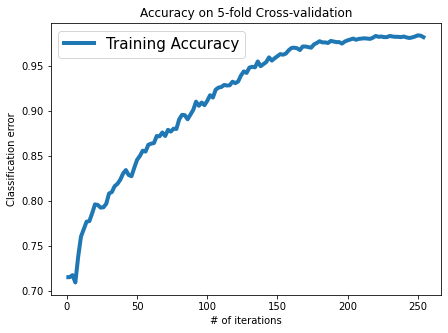

In [33]:
plt.rcParams['figure.figsize'] = 7, 5
plt.plot(iterationsGrid, cvScores, '-', linewidth=4.0, label='Training Accuracy')
plt.title('Accuracy on 5-fold Cross-validation')
plt.xlabel('# of iterations')
plt.ylabel('Classification error')
plt.legend(loc='best', prop={'size':15})

plt.rcParams.update({'font.size': 16})

A partir os resultados obtidos acima, observamos que o modelo mostrou-se robusto à overfitting, de forma com que podemos utilizar valores bastante altos para o número de iterações e atingir resultados muito bons.

#### 3.2 Treino

##### 3.2.1 Exemplo: observando as iterações durante o boosting

Primeiramente, vamos treinar um modelo mais simples, com menor número de iterações, mas apresentando prints sobre o estado do boosting iterativamente.

Mostraremos, para cada iteração, alguns valores relevantes:
- Uma parte dos pesos para cada amostra
- O melhor stump p/ iteração 
- O valor de epsilon (erro ponderado)
- O valor de alpha

In [34]:
n_iter = 4

In [35]:
%%time
ensemble, alphas = boosting(X_train, y_train, [0,1,2,3,4,5,6,7,8], [-1,0,1], n_iter, True)

-------------- Iteration  0 --------------
cur. weights sample:  [0.00130548 0.00130548 0.00130548 0.00130548 0.00130548 0.00130548
 0.00130548 0.00130548 0.00130548 0.00130548 0.00130548 0.00130548]
BestStump:  {'splittingFeature': 4, 'value': -1, 'prediction': -1}
Epsilon:  0.2845953002610977
Alpha:  0.4608901120794606
------------------------------------------
-------------- Iteration  1 --------------
cur. weights sample:  [0.00091241 0.00091241 0.00229358 0.00229358 0.00091241 0.00091241
 0.00091241 0.00091241 0.00091241 0.00229358 0.00091241 0.00091241]
BestStump:  {'splittingFeature': 8, 'value': -1, 'prediction': -1}
Epsilon:  0.35760563851871635
Alpha:  0.29288578723923164
------------------------------------------
-------------- Iteration  2 --------------
cur. weights sample:  [0.00071016 0.00127572 0.00178518 0.00320685 0.00071016 0.00071016
 0.00071016 0.00071016 0.00071016 0.00178518 0.00071016 0.00071016]
BestStump:  {'splittingFeature': 2, 'value': -1, 'prediction': -1}

##### 3.2.2 Treino definitivo

Logo abaixo, realizaremos o treino do modelo com 250 iterações.

In [36]:
%%time
ensemble, alphas = boosting(X_train, y_train, [0,1,2,3,4,5,6,7,8], [-1,0,1], 250)

Wall time: 1.28 s


In [37]:
ensemble

[{'splittingFeature': 4, 'value': -1, 'prediction': -1},
 {'splittingFeature': 8, 'value': -1, 'prediction': -1},
 {'splittingFeature': 2, 'value': -1, 'prediction': -1},
 {'splittingFeature': 0, 'value': -1, 'prediction': -1},
 {'splittingFeature': 6, 'value': -1, 'prediction': -1},
 {'splittingFeature': 4, 'value': 1, 'prediction': 1},
 {'splittingFeature': 7, 'value': -1, 'prediction': -1},
 {'splittingFeature': 2, 'value': 1, 'prediction': 1},
 {'splittingFeature': 6, 'value': 1, 'prediction': 1},
 {'splittingFeature': 0, 'value': 1, 'prediction': 1},
 {'splittingFeature': 5, 'value': -1, 'prediction': -1},
 {'splittingFeature': 8, 'value': 1, 'prediction': 1},
 {'splittingFeature': 1, 'value': -1, 'prediction': -1},
 {'splittingFeature': 3, 'value': -1, 'prediction': -1},
 {'splittingFeature': 4, 'value': 1, 'prediction': 1},
 {'splittingFeature': 6, 'value': 1, 'prediction': 1},
 {'splittingFeature': 2, 'value': 1, 'prediction': 1},
 {'splittingFeature': 7, 'value': -1, 'predicti

In [38]:
alphas

array([0.46089011, 0.29288579, 0.28801315, 0.27051237, 0.25760764,
       0.19020913, 0.10801129, 0.1235074 , 0.1205649 , 0.11727477,
       0.12259715, 0.12199742, 0.14083052, 0.12534166, 0.11323124,
       0.09567063, 0.09918314, 0.0914556 , 0.10214205, 0.09942471,
       0.10850814, 0.10952228, 0.10644341, 0.09991602, 0.10515756,
       0.09526502, 0.1031139 , 0.08779212, 0.10164823, 0.0918941 ,
       0.08451572, 0.09799058, 0.09260305, 0.10632203, 0.09759243,
       0.08958991, 0.1005079 , 0.09710042, 0.09548905, 0.09750637,
       0.10673145, 0.09348189, 0.0956331 , 0.09396187, 0.09606012,
       0.09337823, 0.09749281, 0.09712923, 0.0904344 , 0.0877726 ,
       0.09486289, 0.10478936, 0.10080457, 0.09583708, 0.09141681,
       0.09578454, 0.09360407, 0.09430311, 0.09940352, 0.0984382 ,
       0.09069244, 0.09436484, 0.09357075, 0.09104117, 0.09300992,
       0.09441326, 0.09237693, 0.09744705, 0.09558163, 0.10441121,
       0.09262383, 0.0954747 , 0.09453582, 0.08894234, 0.09704

#### 3.3 Teste

Em seguida, testamos nossa partição de testes no modelo treinado acima.

In [39]:
y_pred = predict(alphas, ensemble, X_test)

In [40]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9739583333333334
